In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Parâmetros
u0   = 4*np.pi*1e-9 #.. H/cm
urFe = 2500*u0 #....... H/cm
urAr =    1*u0 #....... H/cm
dx   = 1e-1 #............ cm
l    = 22 #.............. cm
h    = 20 #.............. cm
lbd  = 1.75 #     lambda, sobrerrelaxação
tol  = 1e-4 # tolerância, sobrerrelaxação

def gera_grid(dx, l, h):
    '''
    Função que cria, a partir das dimensões do espaço `l` e `h` e a partir da
    discretização deste espaço `dx` (=`dy`) um grid que o descreve
    
    Parameters
    ----------
    dx: float
        passo
    l: float
        largura do grid
    h: float
        altura do grid

    Returns
    -------
    M: int
        tamanho da grade em x
    N: int
        tamanho da grade em y
    X: np.ndarray, dim=(N, M)
        meshgrid em x
    Y: np.ndarray, dim=(N, M)
        meshgrid em y
    grid: np.ndarray, dim=(N, M)
        grid do sistema, inicialmente em branco
    '''
    # dimensões do grid
    M = int(l/dx) + 1
    N = int(h/dx) + 1

    # inicializando o grid
    grid = np.zeros((N, M))

    # criando dois vetores lineares x e y e os usando de base
    # para as matrizes X e Y, resultantes do meshgrid
    x = np.linspace(0, l, M)
    y = np.linspace(-h/2, h/2, N)
    X, Y = np.meshgrid(x, y)


    return M, N, X, Y, grid

def define_elementos(X, Y, grid):
    '''
    Função que toma o `grid`, gerado pelo método `gera_grid()` e o completa
    com a identificação dos elementos que o compõe cada qual em sua posição

    Parameters
    ----------
    X: np.ndarray, dim=(N, M)
        meshgrid em x
    Y: np.ndarray, dim=(N, M)
        meshgrid em y
    grid: np.ndarray, dim=(N, M)
        grid do sistema, inicialmente em branco

    Notes
    -----
    Para tornar o EP mais dinâmico e eficiente, decidiu-se criar apenas um
    grid composto por elementos infinitesimais que indicam o meio ao qual
    pertencem. Para tanto, utilizou-se a seguinte notação:
    - 0: pontos que não fazem parte do grid (resto que fica acima e abaixo
         da parte à direita da bobina, para preencher o espaço retangular)
    - 1: entreferro
    - 2: armadura
    - 3: núcleo de ferro
    - 4: bobina_LE
    - 5: bobina_LD
    Com este método, todas as grandezas que dependem do meio podem facilmente
    ser definidas e, apenas com uma matriz, é possível descrever por exemplo
    a corrente Jz em todo o sistema (podemos filtrar os pontos em que temos
    a bobina e tornar todo o resto da matriz 0)
    '''
    # definindo as regiões dos diferentes elementos
    armadura = (X <= 4)
    entreferro = np.logical_or(
        # primeiro retângulo, 
        # -10 <  y <  10
        #   4 <  X <   5
        np.logical_and(X > 4, X < 5),
        # região do meio,
        #  -6 <  y <   6
        #   5 <= x <  14
        np.logical_and(
            np.logical_and(X >= 5, X < 14),
            np.logical_and(Y > -6, Y < 6)
            )
        )

    nucleo = np.logical_or(
        # pontas
        # y <= -6 | y >= 6
        # 5 <= x <  20
        np.logical_and(
            np.logical_and(X >= 5, X <= 20),
            np.logical_or(Y <= -6, Y >= 6)
            ),
        # barra vertical (entre as bobinas)
        # -10 <  y <  10
        #  16 <  x <  16
        np.logical_and(X > 16, X < 20)
        )

    bobina_LE =  np.logical_and(
        # bobina da esquerda (corrente entrando na folha)
        #  -6 <= y <=  6
        #  14 <= x <  16
        np.logical_and(X >= 14, X <= 16),
        np.logical_and(Y >= -6, Y <=  6)
        )
    
    bobina_LD = np.logical_and(
        # bobina da direita (corrente saindo da folha)
        #  -6 <= y <=  6
        #  20 <= x <  22
        np.logical_and(X >= 20, X <= 22),
        np.logical_and(Y >= -6, Y <=  6)
        )
        

    # assignando os códigos de cada região (regiões não assignadas não fazem
    # parte do sistema, região externa, continuam em 0)
    grid[entreferro]    = 1
    grid[armadura]      = 2
    grid[nucleo]        = 3
    grid[bobina_LE]     = 4
    grid[bobina_LD]     = 5
    
    return grid

M, N, X, Y, grid = gera_grid(dx, l, h)
grid = define_elementos(X, Y, grid)
A = np.zeros((N, M))

def calcula_J(y):
    '''
    Função auxiliar que calcula a corrente dado um ponto y
    '''
    return 2e6*np.cos(np.pi*y/12e-2) + 8e5

def itera_A(A, grid, N, M, Y):
    A_ = A.copy()
    for j in range(1, N-1):
        for i in range(1, M-1):
            if grid[j, i] == 0:
                A_[j, i] = 0
            elif grid[j, i] in [1, 2, 3]:
                A_[j, i] = 1/4 * (A[j+1, i] 
                               + A[j-1, i]
                               + A[j, i-1]
                               + A[j, i+1])
            elif grid[j, i] == 4:
                y = Y[j, 0]
                A_[j, i] = 1/4 * (A[j+1, i] 
                               + A[j-1, i]
                               + A[j, i-1]
                               + A[j, i+1]
                               + dx**2*urAr*calcula_J(y))
            # na bobina e na interface entreferro-bobina
            elif grid[j, i] == 5:
                y = Y[j, 0]
                A_[j, i] = 1/4 * (A[j+1, i] 
                               + A[j-1, i]
                               + A[j, i-1]
                               + A[j, i+1]
                               - dx**2*urAr*calcula_J(y))
            elif grid[j, i] == 6:
                uAntes  = urAr
                uDepois = urFe
                alfa = 1 + uDepois/uAntes
                A_[j, i] = 1/(4*alfa) * (alfa*(A[j + 1, i] + A[j - 1, i])
                                      + 2*(A[j, i + 1] + (alfa - 1)*A[j, i - 1]))

            elif grid[j, i] == 7:
                uAntes  = urAr
                uDepois = urFe
                alfa = 1 + uDepois/uAntes
                A_[j, i] = 1/(4*alfa) * (2*(A[j + 1, i] + (alfa - 1)*A[j - 1, i])
                                       + alfa*(A[j, i + 1] + A[j, i - 1]))

            elif grid[j, i] == 8:
                uAntes  = urFe
                uDepois = urAr
                alfa = 1 + uDepois/uAntes
                A_[j, i] = 1/(4*alfa) * (alfa*(A[j + 1, i] + A[j - 1, i])
                                      + 2*(A[j, i + 1] + (alfa - 1)*A[j, i - 1]))

            elif grid[j, i] == 9:
                uAntes  = urFe
                uDepois = urAr
                alfa = 1 + uDepois/uAntes
                A_[j, i] = 1/(4*alfa) * (2*(A[j + 1, i] + (alfa - 1)*A[j - 1, i])
                                       + alfa*(A[j, i + 1] + A[j, i - 1]))
    
    aplica_cc(A_, grid)
    return A_

def aplica_cc(A, grid):
    '''
    Função que aplica as condições de contorno em A, o que inclui
    as condições de Dirichlet (potencial na fronteira externa constante
    e igual a 0) e também zera o potencial para os pontos do grid que
    "não pertencem" ao problema (pontos que foram anexados para tornar)
    o grid regular, mas que não fazem parte do problema
    '''
    # bordas com potencial nulo
    A[ 0,  :] = 0
    A[-1,  :] = 0
    A[ :,  0] = 0
    A[ :, -1] = 0
    # zera partes que não pertencem ao problema
    A         = np.where(grid==0, 0, A)

def dif_central(A, i, j, dx):
    """
    Calcula as derivadas parciais, por meio da diferença central em relação as 
    variáveis x e y, dada uma matriz A e o ponto (i, j) do qual se deseja as 
    derivadas.
    
    Parameters
    ----------
    A: np.ndarray, dim=(N, M)
        valores de Az
    i: int
        linha da qual se deseja calcular
    j: int
        coluna da qual se deseja calcular
    dx: float
        passo
    
    Returns
    -------
    delA_delx: float
        valor da derivada parcial calculada em relação a variável x
    delA_dely: float
        valor da derivada parcial calculada em relação a variável y
    """
    delA_delx = (A[j-1, i] - A[j+1, i])/(2*dx)
    
    delA_dely = (A[j, i-1] - A[j, i+1])/(2*dx)
    
    return delA_delx, delA_dely 


def dif_progressiva(A, i, j, dx):
    """
    Calcula a derivada parcial, por meio da diferença progressiva de 3 pontos 
    em relação a x e y  dada uma matriz A e o ponto (i, j) do qual se 
    deseja a derivada.
    
    Parameters
    ----------
    A: np.ndarray, dim=(N, M)
        valores de Az
    i: int
        linha da qual se deseja calcular
    j: int
        coluna da qual se deseja calcular
    dx: float
        passo
    
    Returns
    -------
    delA_delx: float
        valor da derivada parcial calculada em relação a variável x
    delA_dely: float
        valor da derivada parcial calculada em relação a variável y
    """
    delA_delx = (-A[j+2, i] + 4*A[j+1, i]-3*A[j, i])/(2*dx)
    delA_dely = (-A[j, i+2] + 4*A[j, i+1]-3*A[j, i])/(2*dx)
    return delA_delx, delA_dely 


def dif_regressiva(A, i, j, dx):
    """
    Calcula a derivada parcial, por meio da diferença regressiva de 3 pontos 
    em relação a variável  dada uma matriz A e o ponto (i, j) do qual se 
    deseja a derivada.
    
    Parameters
    ----------
    A: np.ndarray, dim=(N, M)
        valores de Az
    i: int
        linha da qual se deseja calcular
    j: int
        coluna da qual se deseja calcular
    dx: float
        passo
    
    Returns
    -------
    delA_delx: float
        valor da derivada parcial calculada em relação a variável x
    delA_dely: float
        valor da derivada parcial calculada em relação a variável y
    """
    delA_delx = (A[j+2, i] - 4*A[j+1, i]+3*A[j, i])/(2*dx)
    delA_dely = (A[j, i+2] - 4*A[j, i+1]+3*A[j, i])/(2*dx)
    return delA_delx, delA_dely 

def calcula_B(A, N, M, dx, mu):
    """
    Calcula o vetor B ponto a ponto e retorna um array que são as
    componentes em x e outro que são as componentes em y.
    
    Parameters
    ----------
    A: np.ndarray, dim=(N, M)
        valores de Az
    M: int
        tamanho da grade em x
    N: int
        tamanho da grade em y
    
    Returns
    -------
    Bx: np.ndarray, dim=(N, M)
        matriz das componentes de Bx
    By: np.ndarray, dim=(N, M)
        matriz das componentes de By
    """
    Bx = np.zeros_like(A)
    By = np.zeros_like(A)
    for j in range(1, N-1):
        for i in range(1, M -1):
            uC = mu[j + 1,     i]
            uB = mu[j - 1,     i]
            uE = mu[    j, i - 1]
            uD = mu[    j, i + 1]
            
            delA_delx = (A[j+1, i] - A[j-1, i])/(((uB/uC) + 1)*dx)
            delA_dely = (A[j, i+1] - A[j, i-1])/(((uD/uE) + 1)*dx)

            Bx[j, i] = delA_dely
            By[j, i] = -delA_delx
    
    return Bx, By

def gera_mu(grid, urAr, urFe):
    '''
    Método que gera uma matriz com o valor das permeabilidades
    para cada elemento do grid

    Parameters
    ----------
    grid: np.ndarray, dim=(N, M)
        grid do sistema, contém as identificações dos elementos
    urAr: float
        permeabilidade magnética do ar
    urFe: float
        permeabilidade magnética do ferro

    Returns
    -------
    mu: np.ndarray, dim=(N, M)
        valores da permeabilidade (mu) em cada meio
    '''
    mu = np.piecewise(grid, 
        [
        grid==0,  #vazios      - mu_Ar
        grid==1,  #entreferro  - mu_Ar
        grid==2,  #armadura    - mu_Fe
        grid==3,  #nucleoFerro - mu_Fe
        grid==4,  #bobinaLE    - mu_Ar
        grid==5   #bobinaLD    - mu_Ar
        ], 
        [urAr, urAr, urFe, urFe, urAr, urAr]
    )
    return mu

def calcula_H(B, mu):
    """
    Função que calcula o vetor H, ou a componente relativa do vetor,
    a partir de um vetor B, ou de uma componente do vetor, e do vetor de mus
     Parameters
    ----------
    B: np.ndarray, dim=(N, M)
        matriz das componentes de B
    mu: np.ndarray, dim=(N, M)
        valores da permeabilidade (mu) em cada meio
    
    Returns
    -------
    H: np.ndarray, dim=(N, M)
        valores da componente de H
    """
    H = np.divide(B, mu)
    return H

def calcula_F(Bx, By, mu_0, grid):
    """
    Função que calcula as forças nas direções x e y para a armadura.
    Ela é dada pela integral de linha seguindo o contorno na armadura, que 
    neste caso foi discretizada em 4 partes.
    
     Parameters
    ----------
    Bx: np.ndarray, dim=(N, M)
        matriz das componentes de Bx
    By: np.ndarray, dim=(N, M)
        matriz das componentes de By
    mu_0: float
        valor da permiabilidade absoluta
    grid: np.ndarray, dim=(N, M)
        grid do sistema, com os elementos definidos
        

    Returns
    -------
    Fela_x: float
        valor da componente x da força resultante do campo B
    Fela_y:
        valor da componente y da força resultante do campo B
    """
    max_y, max_x = max(np.where(grid == 2)[0]), max(np.where(grid == 2)[1])
    min_y, min_x = min(np.where(grid == 2)[0]), min(np.where(grid == 2)[1])
    
    print(min_x, max_x, min_y, max_y)
    
    Bx2_By2 = Bx**2 - By**2
    
    BxBy = 2*np.multiply(Bx, By)
    
    Fela_x = 1/(2*mu_0) * (
          np.trapz(Bx2_By2[min_y:max_y,       max_x])
        - np.trapz(   BxBy[      max_y, min_x:max_x])
        + np.trapz(Bx2_By2[min_y:max_y,       min_x])
        - np.trapz(   BxBy[      min_y, min_x:max_x])
    )
    
    Fela_y = 1/(2*mu_0) * (
              np.trapz(   BxBy[min_y:max_y,       max_x])
            - np.trapz(Bx2_By2[      max_y, min_x:max_x])
            + np.trapz(   BxBy[min_y:max_y,       min_x])
            - np.trapz(Bx2_By2[      min_y, min_x:max_x])
    )

    return Fela_x, Fela_y


In [4]:
Anew   = np.genfromtxt('Anew.csv', delimiter=',')
dx = 1e-1
l = 22
h = 20
M, N, X, Y, grid = gera_grid(dx, l, h)
grid = define_elementos(X, Y, grid)
mu = gera_mu(grid, urAr, urFe)

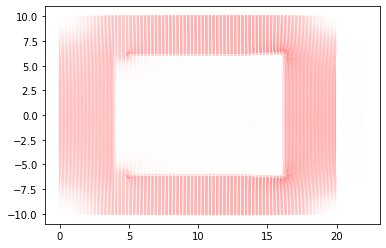

In [51]:
v, u = np.gradient(Anew)
Q = plt.quiver(X, Y, u, v, color='red', width=0.0005, minshaft = 1, minlength=0.1)

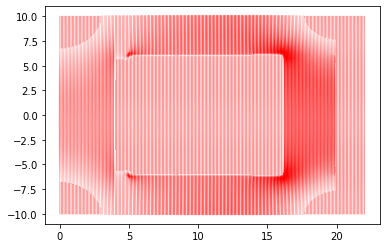

In [37]:
plt.quiver(X, Y, u, v, color='red')

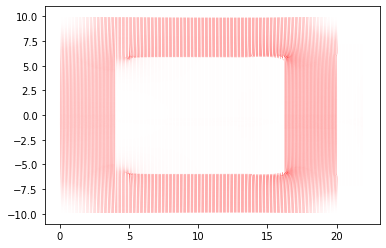

In [7]:
Bx, By = calcula_B(Anew, N, M, dx, mu)
Q = plt.quiver(X, Y, Bx, By, color='red', width=0.0005, minshaft = 1, minlength=0.1)

In [87]:
Bx[0, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
v, u = np.gradient(Anew)
Hx = calcula_H(u, mu)
Hy = calcula_H(v, mu)

Hx = calcula_H(Bx, mu)
Hy = calcula_H(By, mu)


Q = plt.quiver(X, Y, Hx, Hy, color='red', width=0.0005, minshaft = 1, minlength=0.1)

NameError: name 'Bx' is not defined

In [102]:
max_y, max_x = max(np.where(grid == 2)[0]), max(np.where(grid == 2)[1])
min_y, min_x = min(np.where(grid == 2)[0]), min(np.where(grid == 2)[1])

print(min_x, max_x, min_y, max_y)

Bx2_By2 = Bx**2 - By**2

BxBy = 2*np.multiply(Bx, By)

Bx2_By2[:, 0] #primeira coluna
BxBy[0, :] #primeira linha

BxBy[:, 0]

0 40 0 200


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [35]:
mu_0 = u0
max_y, max_x = max(np.where(grid == 2)[0]), max(np.where(grid == 2)[1])
min_y, min_x = min(np.where(grid == 2)[0]), min(np.where(grid == 2)[1])

print(min_x, max_x, min_y, max_y)

Bx2_By2 = Bx**2 - By**2
BxBy = 2*np.multiply(Bx, By)

print(BxBy.shape, Bx2_By2.shape)
Fela_x = 1/(2*mu_0) * (
          np.trapz(Bx2_By2[min_y:max_y,       max_x])
        - np.trapz(   BxBy[      max_y, min_x:max_x])
        + np.trapz(Bx2_By2[min_y:max_y,       min_x])
        - np.trapz(   BxBy[      min_y, min_x:max_x])
    )
    
Fela_y = 1/(2*mu_0) * (
          np.trapz(   BxBy[min_y:max_y,       max_x])
        - np.trapz(Bx2_By2[      max_y, min_x:max_x])
        + np.trapz(   BxBy[min_y:max_y,       min_x])
        - np.trapz(Bx2_By2[      min_y, min_x:max_x])
)
#calcula_F(Bx, By, u0, grid)
Fela_x, Fela_y

0 40 0 200
(201, 221) (201, 221)


(10.616432694309985, -0.0014901632587201025)

In [26]:
#np.trapz(   BxBy[      min_y, min_x:max_x], axis=1)
BxBy[min_y, min_x:max_x]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [73]:
max_x, max_y = max(np.where(grid == 2)[0]), max(np.where(grid == 2)[1])
min_x, min_y = min(np.where(grid == 2)[0]), min(np.where(grid == 2)[1])
max_x, min_x, max_y, min_x

(200, 0, 40, 0)

Using matplotlib backend: MacOSX


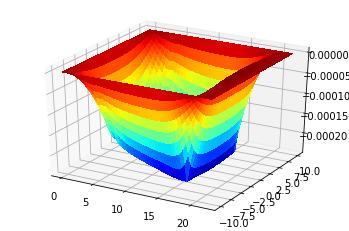

In [306]:
%matplotlib
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Anew, cmap=cm.jet,
                       linewidth=0, antialiased=False)

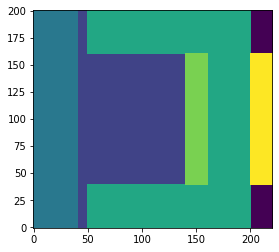

In [52]:
%matplotlib inline
plt.imshow(grid, origin='lower', interpolation="none")

In [78]:
Bx2_By2 = Bx**2 - By**2
    
BxBy = 2*np.multiply(Bx, By)

Bx2_By2.shape, BxBy.shape

((201, 221), (201, 221))

In [20]:
mu[:, -3:]

array([[1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663706e-08, 1.25663706e-08],
       [1.25663706e-08, 1.25663

In [101]:
%matplotlib
plt.imshow(Bx, origin='lower', interpolation="none")

Using matplotlib backend: MacOSX


In [62]:
Bx[-1, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

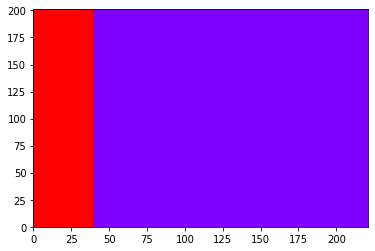

In [116]:
plt.pcolor(grid==2, cmap=plt.cm.rainbow)


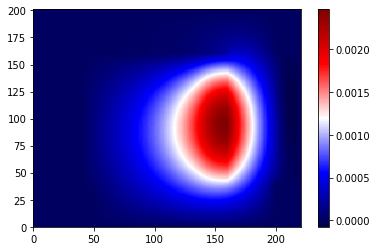

In [83]:
plt.pcolor(A, cmap=plt.cm.seismic)
plt.colorbar()
plt.show()

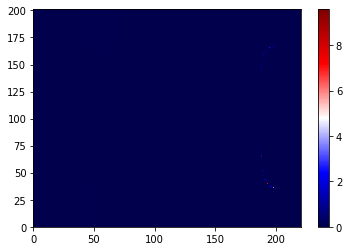

In [75]:
plt.pcolor(np.abs(np.divide(Anew - A, Anew, out=np.zeros_like(Anew), where=Anew!=0)), cmap=plt.cm.seismic)
plt.colorbar()
plt.show()

In [24]:
A_ = itera_A(A_, grid, N, M, Y)

In [44]:
erro

0.002984255911704369

In [32]:
np.max(np.abs(np.divide(A_ - A, A_, out=np.zeros_like(A), where=A!=0)))

0.0

In [35]:
np.divide(A_ - A, A_, out=np.zeros_like(A), where=A!=0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

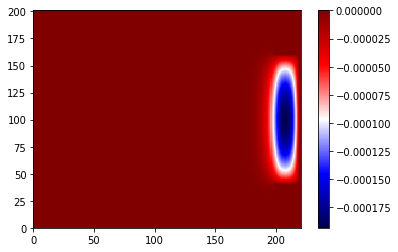

In [56]:
plt.pcolor(Anew, cmap=plt.cm.seismic)
plt.colorbar()
plt.show()

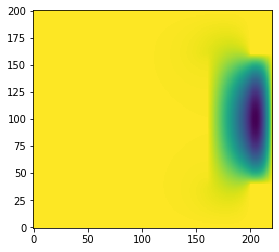

In [50]:
plt.imshow(Anew, origin='lower', interpolation="none")

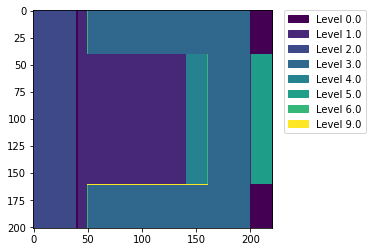

In [87]:
import matplotlib.patches as mpatches
values = np.unique(grid.ravel())

plt.figure(figsize=(8,4))
im = plt.imshow(grid, interpolation='none')
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()
#plt.imshow(grid, origin='lower', interpolation="none")
